# Making Many Filtered Maps

I need to generate many filtered maps at the same time to look at the population of them.

## Boilerplate

In [1]:
import logging
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pysm3.units as u

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    get_planck_noise_data, 
    get_planck_hm_data, 
    get_map_dtype
    )
from cmbml.utils.fits_inspection import get_field_unit

from system_config import ASSETS_DIRECTORY, NOISE_DIRECTORY

In [2]:
# Logging was helpful when debugging my handle_data module
logging.basicConfig(
    level=logging.WARNING,  # If DEBUG, there's a bunch of PySM3 and Matplotlib stuff
    format='%(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [3]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"({ps_s[0].unit:latex_inline})"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [4]:
CENTER_FREQS = {
    30: 28.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    44: 44.1 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    70: 70.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    100: 100.89 * u.GHz,   # Value from Planck DeltaBandpassTable
    143: 142.876 * u.GHz,  # Value from Planck DeltaBandpassTable
    217: 221.156 * u.GHz,  # Value from Planck DeltaBandpassTable
    353: 357.5 * u.GHz,    # Value from Planck DeltaBandpassTable
    545: 555.2 * u.GHz,    # Value from Planck DeltaBandpassTable
    857: 866.8 * u.GHz,    # Value from Planck DeltaBandpassTable
}

In [5]:
def get_xxcov_field_num(detector, field_str):
    if detector not in [30, 44, 70, 100, 143, 217, 353, 545, 857]:
        raise ValueError(f"Detector {detector} not recognized")
    field_str = field_str.lower()
    lower_field_nums = dict(ii=4, iq=5, iu=6, qq=7, qu=8, uu=9)
    upper_field_nums = dict(ii=2)  # These detectors only have intensity data
    if detector in [545, 857]:
        if field_str not in upper_field_nums.keys():
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = upper_field_nums[field_str]
    else:
        if field_str not in ['ii', 'iq', 'iu', 'qq', 'qu', 'uu']:
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = lower_field_nums[field_str]
    return res

In [6]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [7]:
def get_unit_from_str(unit_str):
    if unit_str in ['uK_CMB']:
        return u.uK_CMB
    elif unit_str in ['Kcmb', 'K_CMB']:
        return u.K_CMB
    elif unit_str in ['MJy/sr']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

def get_sqrt_unit_from_str(unit_str):
    if unit_str in ['Kcmb^2', '(K_CMB)^2', 'K_CMB^2']:
        return u.K_CMB
    elif unit_str in ['uK_CMB^2', '(uK_CMB)^2']:
        return u.uK_CMB
    elif unit_str in ['(MJy/sr)^2', '(Mjy/sr)^2', 'MJy/sr^2']:
        return u.MJy / u.sr
    else:
        raise ValueError(f"Unit {unit_str} not recognized")

In [8]:
def get_scale_map(det, nside_out):
    obs_fn = get_planck_obs_data(detector=det, assets_directory=ASSETS_DIRECTORY)
    use_field = get_xxcov_field_num(det, 'II')
    II_cov_map = hp.read_map(obs_fn, hdu=1, field=use_field)
    II_cov_map_512 = _change_variance_map_resolution(II_cov_map, nside_out)
    scale_map = np.sqrt(II_cov_map_512)

    var_map_unit = get_field_unit(obs_fn, hdu=1, field_idx=use_field)
    var_map_unit = get_sqrt_unit_from_str(var_map_unit)
    scale_map = scale_map * var_map_unit
    scale_map = u.Quantity(scale_map, unit=var_map_unit)

    return scale_map

In [9]:
def make_tgt_noise_params(det, n_sims):
    data = np.load(f"noise_models/noise_model_{det}GHz.npz")

    src_mean_ps     = data['mean_ps']
    src_components  = data['components']
    src_variance    = data['variance']

    src_mean_maps   = data['maps_mean']
    src_sd_maps     = data['maps_sd']
    src_map_unit    = data['maps_unit']

    num_components = len(src_variance)

    std_devs = np.sqrt(src_variance)

    if n_sims == 1:
        reduced_samples = np.random.normal(0, std_devs, (num_components,))
        # Reconstruct power spectra in log10 space
        tgt_log_ps = reduced_samples @ src_components + src_mean_ps
        # Convert out of log10 space
        tgt_cls = 10**tgt_log_ps
    else:
        reduced_samples = np.random.normal(0, std_devs, (n_sims, num_components))
        # Reconstruct power spectra in log10 space
        tgt_log_ps = reduced_samples @ src_components + src_mean_ps
        # Convert out of log10 space
        tgt_cls = 10**tgt_log_ps

    src_map_unit = get_unit_from_str(src_map_unit)

    return tgt_cls, src_mean_maps, src_sd_maps, src_map_unit

# Start Here

In [10]:
def make_filter_noise_map(detector, n_sims, seed=42, nside_out=512, return_dict=False):
    # Set parameters
    np.random.seed(seed)
    lmax = 3*nside_out-1
    rng = np.random.default_rng(seed)

    # Get target noise parameters
    tgt_cl, tgt_dist_mean, tgt_dist_sd, tgt_unit = make_tgt_noise_params(detector, n_sims=n_sims)

    tgt_cl = tgt_cl * tgt_unit**2
    min_dist_t = (tgt_dist_mean - 3*tgt_dist_sd)              * tgt_unit  # outside this range, adjust monopole
    max_dist_t = (tgt_dist_mean + 3*tgt_dist_sd)              * tgt_unit

    # Get target means and sign
    tgt_means = np.random.normal(tgt_dist_mean, tgt_dist_sd, size=(n_sims, tgt_dist_mean.size)) * tgt_unit
    tgt_signs = np.sign(tgt_means)

    # Make aniso white noise maps
    scale_map = get_scale_map(detector, nside_out)
    wht_nse_map = rng.normal(size=(n_sims, scale_map.size)) * scale_map

    # Check for unit consistency (both target and white should be in source units, either K_CMB or MJy/sr)
    assert tgt_unit == wht_nse_map.unit, f"Stopping. tgt_unit is {tgt_unit}, wht_nse_map.unit is {wht_nse_map.unit}"

    # Reverse sign of aniso white noise map if needed
    wht_means  = wht_nse_map.mean(axis=1)
    wht_signs  = np.sign(wht_means).reshape(tgt_signs.shape)
    flip_signs = wht_signs * tgt_signs

    wht_nse_map = wht_nse_map * flip_signs

    if return_dict:
        res = dict(
            tgt_cls=tgt_cl,
            tgt_means=tgt_means,
            wht_maps=wht_nse_map,
            wht_cls=[],
            wht_means=wht_nse_map.mean(axis=1),
            filters=[],
            filtered_maps=[]
        )
    else:
        res = []

    # Make map filter, non-vectorized because healpy (improvements welcomed!)
    for i in range(n_sims):
        wht_nse_alms  = hp.map2alm(wht_nse_map[i], lmax=lmax)
        wht_nse_cl    = hp.alm2cl(wht_nse_alms) * wht_nse_map.unit**2
        map_filter    = np.sqrt(tgt_cl[i][:lmax+1] / wht_nse_cl)

        # Filter map
        filtered_alms = hp.almxfl(wht_nse_alms, map_filter)
        filtered_map  = hp.alm2map(filtered_alms, nside=nside_out) * tgt_unit
        # filtered_cl   = hp.anafast(filtered_map, lmax=lmax) * filtered_map.unit**2

        if return_dict:
            res['wht_cls'].append(wht_nse_cl)
            res['filters'].append(map_filter)
            res['filtered_maps'].append(filtered_map)
        else:
            res.append(filtered_map)

    return res

    # Adjust monopole if needed
    # if filtered_map.mean() < min_dist_t or filtered_map.mean() > max_dist_t:
    #     filtered_map = filtered_map + tgt_mean - filtered_map.mean()

    ###############################################
    # Done! The remainder is for display purposes #
    ###############################################

    # # Get noise map cl for comparison
    # nse_fn0      = get_planck_noise_data(detector=detector, 
    #                                      assets_directory=NOISE_DIRECTORY, 
    #                                      realization=src_nse_realization)
    # src_nse_map  = hp.read_map(nse_fn0)
    # src_nse_unit = get_field_unit(nse_fn0, hdu=1, field_idx=0)
    # src_nse_unit = get_unit_from_str(src_nse_unit)
    # src_nse_map  = src_nse_map * src_nse_unit

    # # Convert units to uK_CMB if they were K_CMB
    # if src_nse_map.unit == u.K_CMB:
    #     wht_nse_map = wht_nse_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(CENTER_FREQS[detector]))
    #     wht_nse_cl  = hp.anafast(wht_nse_map, lmax=lmax) * wht_nse_map.unit**2

    #     src_nse_map = src_nse_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(CENTER_FREQS[detector]))
    #     src_nse_cl  = hp.anafast(src_nse_map, lmax=lmax) * src_nse_map.unit**2

    #     tgt_cl      = tgt_cl.to(u.uK_CMB**2, equivalencies=u.cmb_equivalencies(CENTER_FREQS[detector]))

    #     filtered_map = filtered_map.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(CENTER_FREQS[detector]))
    #     filtered_cl  = filtered_cl.to(u.uK_CMB**2, equivalencies=u.cmb_equivalencies(CENTER_FREQS[detector]))
    # else:
    #     src_nse_cl = hp.anafast(src_nse_map, lmax=lmax) * src_nse_map.unit**2

    # # Check for unit consistency in power spectra output
    # ps_unit = wht_nse_cl.unit
    # assert ps_unit == tgt_cl.unit, f"Stopping. ps_unit is {ps_unit}, tgt_cl.unit is {tgt_cl.unit}"
    # assert ps_unit == src_nse_cl.unit, f"Stopping. ps_unit is {ps_unit}, src_nse_cl.unit is {src_nse_cl.unit}"
    # assert ps_unit == filtered_cl.unit, f"Stopping. ps_unit is {ps_unit}, filtered_cl.unit is {filtered_cl.unit}"

In [23]:
def downgrade_map_via_alm(some_map, target_nside):
    source_nside = hp.get_nside(some_map)
    assert target_nside <= source_nside/2, "Target nside must be less than the source nside"
    lmax_source = 3 * source_nside - 1
    alm = hp.map2alm(some_map, lmax=lmax_source)

    lmax_target = int(1.5 * target_nside)
    alm_filter = np.zeros(lmax_source+1)
    alm_filter[:lmax_target+1] = 1
    alm_filtered = hp.almxfl(alm, alm_filter)
    some_map_filtered = hp.alm2map(alm_filtered, nside=target_nside)
    return some_map_filtered

In [12]:
det = 545
nside_out = 512

In [13]:
res = make_filter_noise_map(det, n_sims=2, seed=42, nside_out=nside_out, return_dict=True)

In [14]:
[k for k in res.keys()]

['tgt_cls',
 'tgt_means',
 'wht_maps',
 'wht_cls',
 'wht_means',
 'filters',
 'filtered_maps']

In [15]:
wht_noise_maps = res['wht_maps'].copy()
filtered_maps  = res['filtered_maps'].copy()

In [16]:
wht_noise_maps[0]

<Quantity [ 0.00194459, -0.00672886,  0.00485846, ...,  0.00108981,
           -0.00265643,  0.00422677] MJy / sr>

In [17]:
# def make_average_map(map_set, n_to_avg):
#     map_set_arr = np.array(map_set[:n_to_avg])
#     avg_map = np.mean(map_set_arr, axis=0) * map_set[0].unit
#     return avg_map

In [18]:
# avg_wht_map100 = make_average_map(wht_noise_maps, 100)

In [19]:
scale = 1 if det in [545, 857] else 1e6  # Convert to uK unless units are MJy/sr
fn = f"noise_avgs/avg_noise_map_{det}_TQU_100.fits"
planck_nse_avg = hp.read_map(fn) * scale
planck_nse_avg_sm = hp.smoothing(planck_nse_avg, fwhm=np.radians(10/60))

In [24]:
# if nside_out is not the full resolution, need to downgrade the Planck noise average map to match:
need_to_downgrade_avg = hp.get_nside(planck_nse_avg_sm) != nside_out  # a boolean
if need_to_downgrade_avg:
    planck_nse_avg_sm = downgrade_map_via_alm(planck_nse_avg, nside_out)

In [25]:
planck_nse_avg_sm *= filtered_maps[0].unit

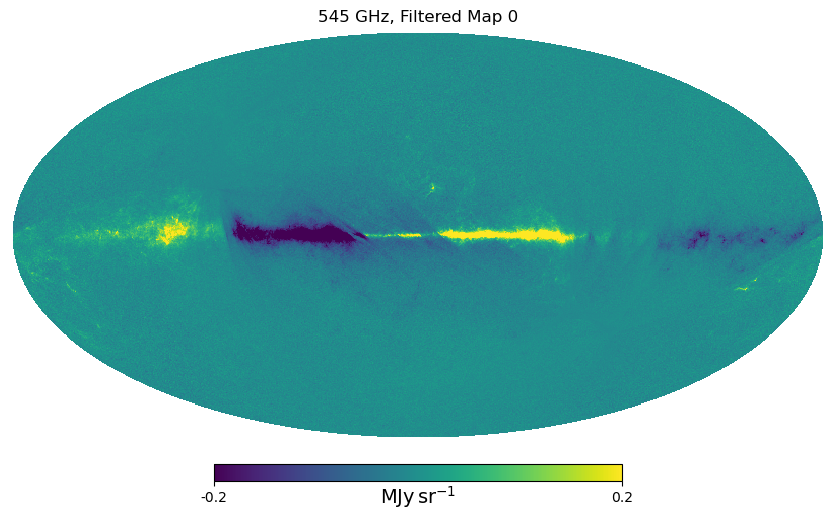

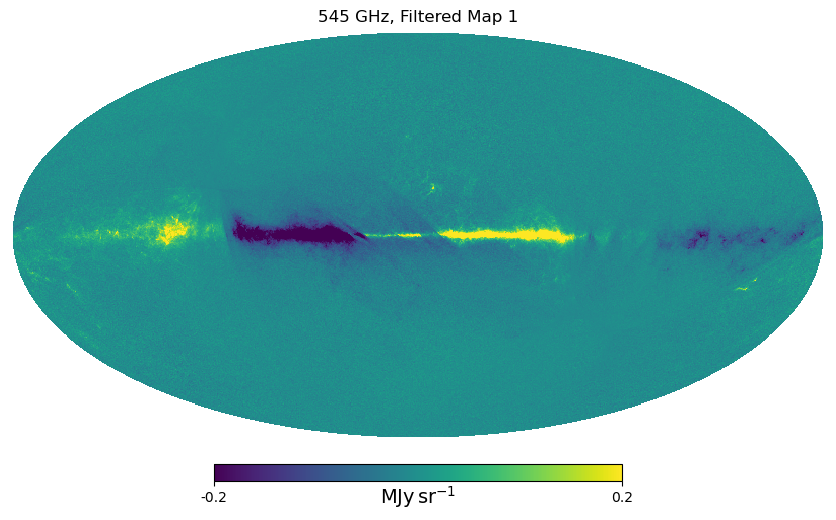

In [26]:
for i in range(2):
    # hp.mollview(filtered_maps[i].to(u.uK_CMB), 
    hp.mollview(filtered_maps[i] + planck_nse_avg_sm, 
                title=f"{det} GHz, Filtered Map {i}", min=-0.2, max=0.2, 
                unit=filtered_maps[i].unit.to_string('latex_inline'))
# hp.mollview(avg_wht_map100.to(u.uK_CMB), 
#             title="White Noise Average", min=-50, max=50, 
#             unit=avg_wht_map100.unit.to_string('latex_inline'))

In [132]:
# avg_filt_map100 = make_average_map(filtered_maps, 100)

In [146]:
# sm_avg_filt = hp.smoothing(avg_filt_map100, fwhm=np.radians(10/60)) * avg_filt_map100.unit

In [54]:
# hp.mollview(filtered_maps[0].to(u.uK_CMB), 
#             title="Filtered Noise Map 1", min=-50, max=50, 
#             unit=filtered_maps[0].unit.to_string('latex_inline'))
# hp.mollview(avg_filt_map100.to(u.uK_CMB), 
#             title="Filtered Noise Average", min=-5, max=5, 
#             unit=avg_filt_map100.unit.to_string('latex_inline'))
# hp.mollview(sm_avg_filt.to(u.uK_CMB), 
#             title="Filtered Noise Average", min=-5, max=5, 
#             unit=sm_avg_filt.unit.to_string('latex_inline'))